## Gender

В одной компании произошла неприятность: случился потоп, в бумажных анкетах клиентов размыло некоторые строки и в 1000 анкетах пострадало поле “gender”. Конечно, их было бы можно восстановить, но в компании решили автоматизировать решение проблемы и определить пол клиентов по фотографиям. Был создан датасет gender.csv, в котором записаны признаки человека на фото и его пол.
Первые 1000 значений имеют пропуски в столбце gender.
Все столбцы с ".1" в названии дублируют предыдущие столбцы без ".1", но содержат уникальные значения
Необходимо произвести чистку данных:
Присоединить дублирующие столбцы к основным.
Столбцы 'nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long', 'long_hair' содержат информацию в условных единицах. Известно, что измерения проводились разными людьми с разными измерительными инструментами, поэтому данные в столбцах имеют разную погрешность измерений. Необходимо уменьшить влияние погрешности путем приравнивания значений диапазона \[0, 0.5) к 0, а [0.5, 1) — к 1.
Столбцы 'forehead_width_cm' и 'forehead_height_cm' необходимо оставить «как есть».
Оставить один из дублирующих друг друга столбцов.Определите пол по остальным параметрам из выборки для первой тысячи значений.

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('gender (1).csv').iloc[:, 2:]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   long_hair                            2515 non-null   float64
 1   forehead_width_cm                    2515 non-null   float64
 2   forehead_height_cm                   2515 non-null   float64
 3   forehead_width_mm                    2515 non-null   float64
 4   forehead_width_conventional_units    2515 non-null   float64
 5   nose_wide                            2515 non-null   float64
 6   nose_long                            2515 non-null   float64
 7   lips_thin                            2515 non-null   float64
 8   distance_nose_to_lip_long            2515 non-null   float64
 9   gender                               1514 non-null   object 
 10  index.1                              2515 non-null   int64  
 11  long_hair.1                   

Очистим датасет от пустых строк, столбцов с индексами и разобьем на два датафрейма: один с пропущенными значениями, которые необходимо предсказать, другой - для обучения и тестирования моделей.
Кроме того, необходимо округлить значения в столбцах 'nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long', 'long_hair' по условию задачи.

In [3]:
data_1 = data.iloc[:, :10]
data_2 = data.iloc[:, 11:]
data_2.rename(columns = lambda x: x.replace(".1", ""), inplace = True)
df_concat = pd.concat([data_1, data_2])
df_concat = df_concat[df_concat.long_hair.isna() == False]
columns_to_round = ['nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long', 'long_hair']

for column in columns_to_round:
    df_concat[column] = np.around(df_concat[column])
df_est = df_concat[df_concat.gender.isna()]
df = df_concat[~df_concat.gender.isna()]

Проверим датасет на наличие выбросов, а также содержатся ли в нем признаки с сильной корреляцией, что может ухудшить работу моделей по причине мультиколлинеарности.

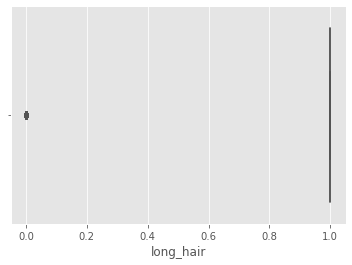

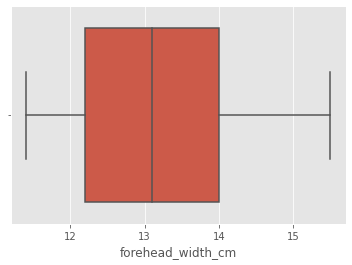

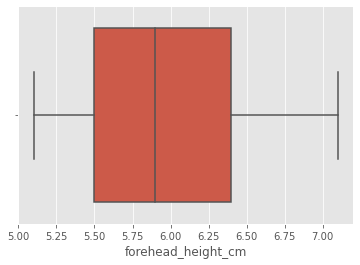

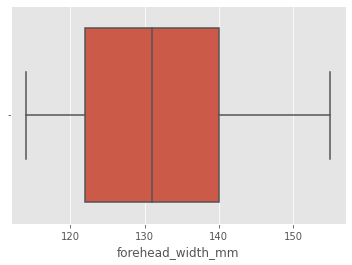

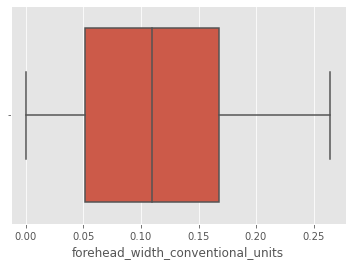

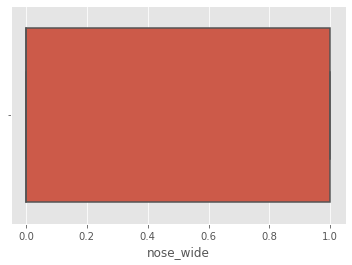

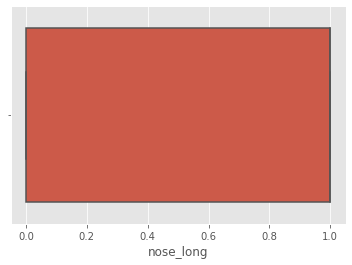

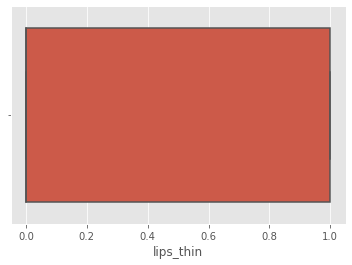

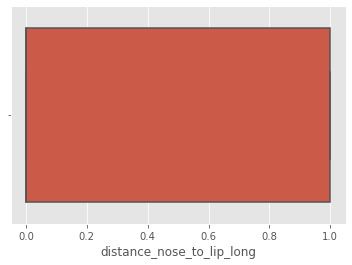

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
for feature in df.columns[:-1]:
    sns.boxplot(df[feature])
    plt.show()

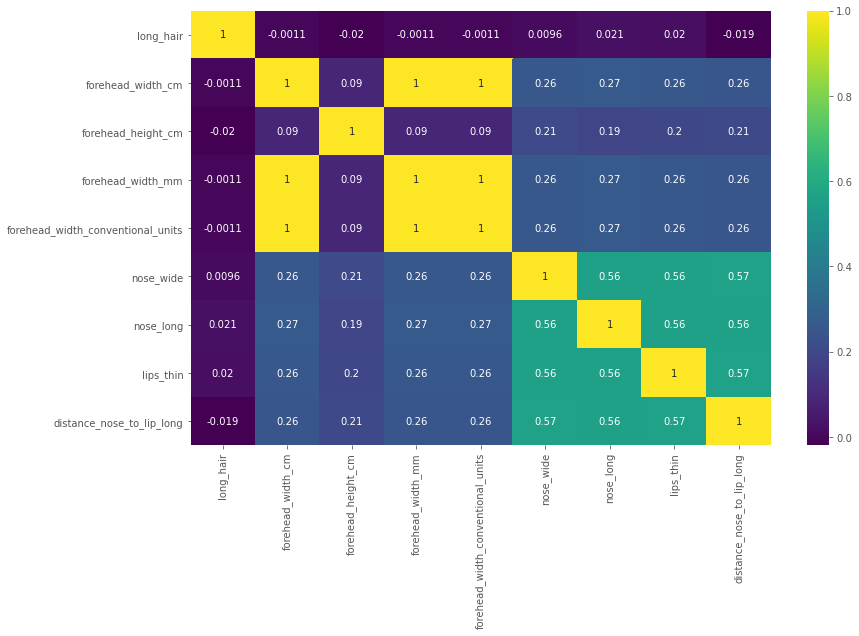

In [5]:
df_corr = df.iloc[:, :-1].corr()
plt.figure(figsize=(13, 8))
sns.heatmap(df_corr, annot = True, cmap = 'viridis')

Проанализировав боксплоты можно сделать вывод о том, что выбросов во всех признаках кроме длины волос нет. Для длины волос низкие значения показателя играют важную роль, так как с большей вероятностью указывают на принадлежность к мужскому полу.
Признаков, сильно коррелирующих друг с другом, не выявлено.

Далее для корректного применения предсказывающей модели заменим целевык значения на нули и единицы и нормируем признаки.

In [6]:
from sklearn.preprocessing import StandardScaler

def encode(x):
    if x == "Male":
        return 1
    return 0

scaler = StandardScaler()
x = df.iloc[:, :9]
y = df.iloc[:, -1].apply(encode)
x = pd.DataFrame(scaler.fit_transform(x))
y.head()

1001    1
1002    1
1003    0
1004    0
1005    0
Name: gender, dtype: int64

In [7]:
x_est = pd.DataFrame(scaler.fit_transform(df_est.iloc[:, :-1]))
x_est.head()

,0,1,2,3,4,5,6,7,8
0,0.403239,-1.254012,0.243623,-1.254012,-1.254012,1.005008,-1.015099,1.007018,0.985126
1,-2.479919,0.746702,-1.069504,0.746702,0.746702,-0.995017,-1.015099,1.007018,-1.015099
2,-2.479919,-1.254012,0.618802,-1.254012,-1.254012,1.005008,0.985126,1.007018,0.985126
3,-2.479919,1.110468,0.243623,1.110468,1.110468,-0.995017,0.985126,1.007018,0.985126
4,0.403239,0.291994,-0.131556,0.291994,0.291994,-0.995017,-1.015099,-0.993031,-1.015099


Создадим несколько моделей и с помощью кросс-валидации отберем лучшую.

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

svc = SVC(C=0.5, kernel='sigmoid', probability=True)
rf_1 = RandomForestClassifier(n_estimators=25, max_depth=3)
rf_2 = RandomForestClassifier(n_estimators = 50, max_depth=2)
rf_3 = RandomForestClassifier(n_estimators = 8, max_depth=2)
knn_1 = KNeighborsClassifier(n_neighbors=5)
knn_2 = KNeighborsClassifier(n_neighbors=10)
knn_3 = KNeighborsClassifier(n_neighbors=15)
nb = GaussianNB()
models = [svc, rf_1, rf_2, rf_3, knn_1, knn_2, knn_3, nb]

In [10]:
svc = SVC(C=0.5, kernel='sigmoid', probability=True)
rf_1 = RandomForestClassifier(n_estimators=25, max_depth=3)
rf_2 = RandomForestClassifier(n_estimators = 50, max_depth=2)
rf_3 = RandomForestClassifier(n_estimators = 8, max_depth=2)
knn_1 = KNeighborsClassifier(n_neighbors=5)
knn_2 = KNeighborsClassifier(n_neighbors=10)
knn_3 = KNeighborsClassifier(n_neighbors=15)
nb = GaussianNB()
models = [svc, rf_1, rf_2, rf_3, knn_1, knn_2, knn_3, nb]

In [11]:
for model in models:
    print((model, np.mean(cross_val_score(model, x, y, cv = 5))))

(SVC(C=0.5, kernel='sigmoid', probability=True), 0.9535)
(RandomForestClassifier(max_depth=3, n_estimators=25), 0.97475)
(RandomForestClassifier(max_depth=2, n_estimators=50), 0.96825)
(RandomForestClassifier(max_depth=2, n_estimators=8), 0.96175)
(KNeighborsClassifier(), 0.9705)
(KNeighborsClassifier(n_neighbors=10), 0.9722500000000001)
(KNeighborsClassifier(n_neighbors=15), 0.9727499999999999)
(GaussianNB(), 0.97)


Подберем гиперпараметры, чтобы улучшить модель rf_1.

In [12]:
rf_1 = RandomForestClassifier(n_estimators=90, max_depth=3, random_state = 42, 
                             bootstrap = False, criterion = "entropy")
np.mean(cross_val_score(rf_1, x, y, cv = 5))

0.976

Сделаем предсказание и сохраним результаты.

In [13]:
rf_1.fit(x, y)
precision = pd.DataFrame(rf_1.predict(x_est))
precision.rename(columns = {0: 'gender'}, inplace = True)

def fill_gender(x):
    if x:
        return "Male"
    return "Female"

precision['answer'] = precision['gender'].apply(fill_gender)
precision.drop('gender', axis = 1, inplace = True)
precision.to_csv('submission.csv', header = False, index = False)